In [1]:
!git clone https://github.com/fastai/course-v3

Cloning into 'course-v3'...
remote: Enumerating objects: 5893, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 5893 (delta 0), reused 2 (delta 0), pack-reused 5890
Receiving objects: 100% (5893/5893), 263.03 MiB | 28.54 MiB/s, done.
Resolving deltas: 100% (3249/3249), done.
Checking out files: 100% (887/887), done.


In [6]:
%cd course-v3/nbs/dl2
%load_ext autoreload
%autoreload 2
%matplotlib inline
from exp.nb_06 import *

/content/course-v3/nbs/dl2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
def get_data():
    path = Path('/content/mnist.pkl.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

x_train, y_train, x_valid, y_valid = get_data()
x_train, x_valid = normalize_to(x_train, x_valid)

In [8]:
train_ds, valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)
nh, bs = 50, 512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)
mnist_view = view_tfm(1, 28, 28)
cbfs = [Recorder,
        partial(AvgStatsCallback, accuracy),
        # CudaCallback,
        partial(BatchTransformXCallback, mnist_view)]
nfs = [8, 16, 32, 64, 64]
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

%time run.fit(2, learn)

train: [1.51115421875, tensor(0.5014)]
valid: [0.324711865234375, tensor(0.8889)]
train: [0.20543708984375, tensor(0.9364)]
valid: [0.12795833740234375, tensor(0.9602)]
CPU times: user 20.2 s, sys: 433 ms, total: 20.6 s
Wall time: 10.8 s


---

A13

In [9]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
            nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

nfs = [8, 16, 32, 32]
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs))

In [10]:
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int, slice)): return self.items[idx]
        if isinstance(idx[0], book):
            assert len(idx) == len(self) #bool mask
            return [item for bool_i, item in zip(idx, self.items) if bool_i]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)> 10: res = res[:-1] + '...]' #[^2]
        return res

from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, modules, f): super().__init__([Hook(module, f) for module in modules])
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.remove()
    def __del__(self): self.remove()
    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
    def remove(self):
        for h in self: h.remove()


In [11]:
model = get_cnn_model(data, nfs, )
learn, run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [2.18296390625, tensor(0.2245)]
valid: [1.79603359375, tensor(0.3534)]
train: [0.954873125, tensor(0.6682)]
valid: [0.34023779296875, tensor(0.8903)]


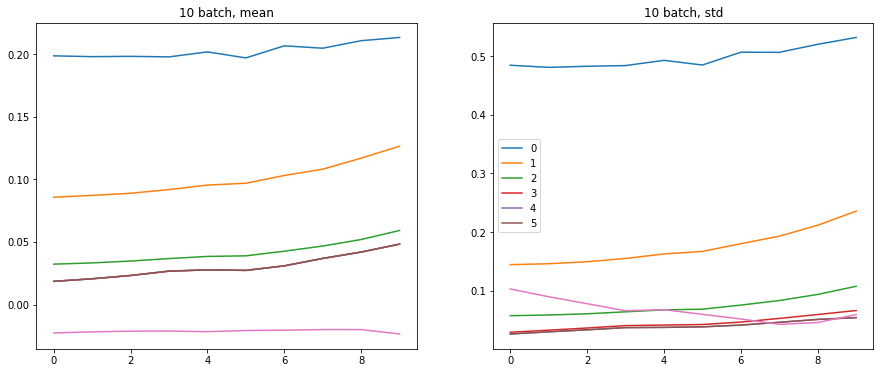

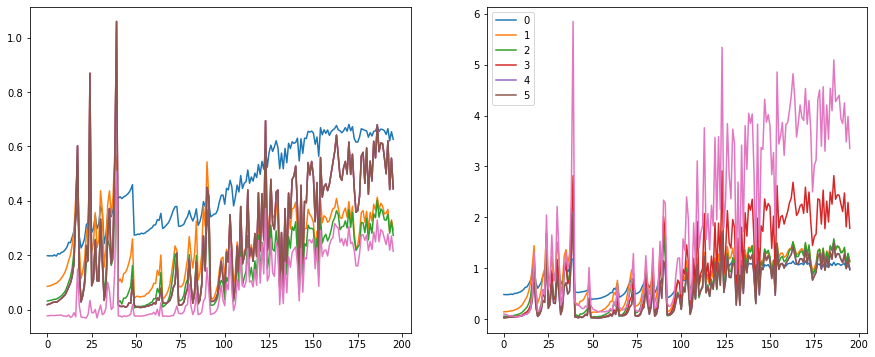

In [12]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))
    ax0.title.set_text('10 batch, mean')
    ax1.title.set_text('10 batch, std')
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6))

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 6))
    for h in hooks:
        ms, ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6))


---

In [13]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(outp.detach().mean().cpu())
    stds .append(outp.detach().std().cpu())
    # https://pytorch.org/docs/stable/generated/torch.histc.html
    hists.append(outp.detach().cpu().histc(40, 0, 10))


model = get_cnn_model(data, nfs)
learn, run = get_runner(model, data, lr=0.9, cbs = cbfs)

with Hooks(model, append_stats) as hooks: run.fit(1, learn)

# https://pytorch.org/docs/stable/generated/torch.log1p.html
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()


train: [1.9692240625, tensor(0.3097)]
valid: [1.554566796875, tensor(0.4480)]


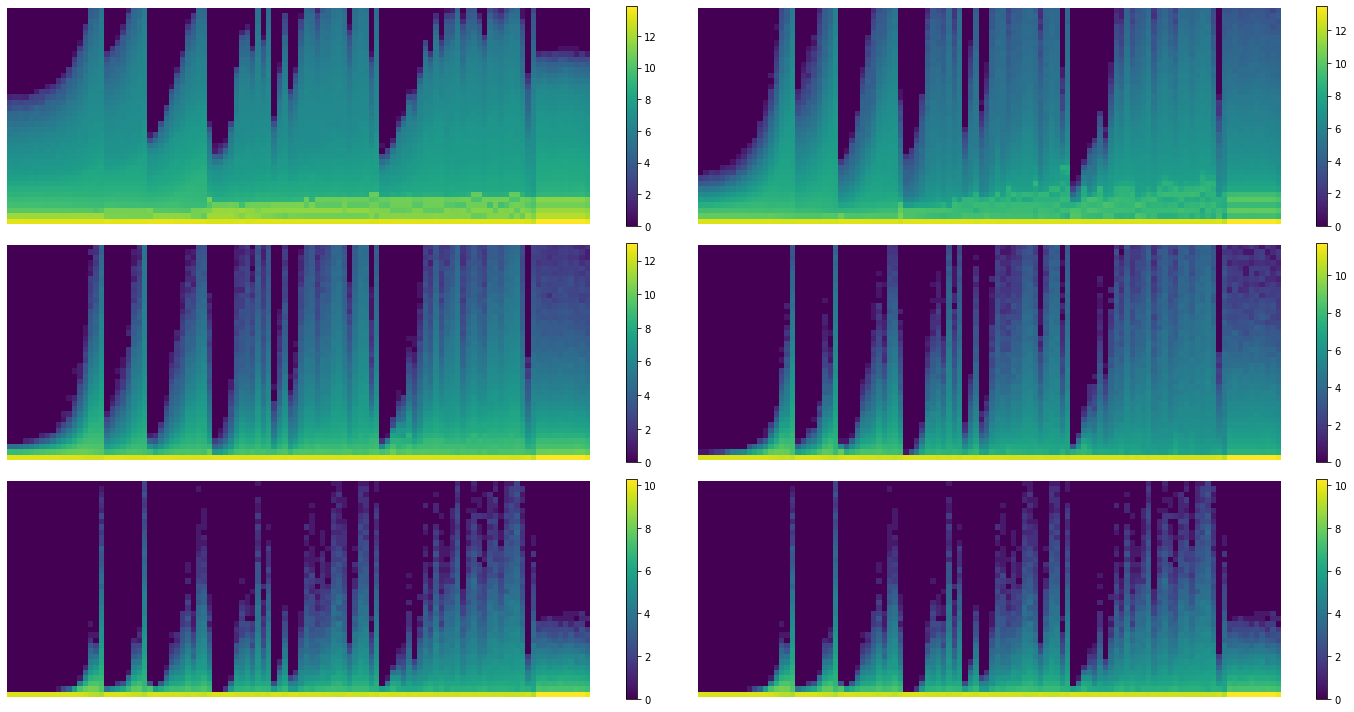

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(20,10))
# axes.shape, axes.flatten().shape
for ax, h in zip(axes.flatten(), hooks[:6]):
    img = ax.imshow(get_hist(h), origin='lower')
    # bar = plt.colorbar(ax)
    ax.axis('off')
    plt.colorbar(img, ax = ax)
# plt.legend()
plt.tight_layout()

In [67]:
model[0](xb).shape

torch.Size([512, 8, 14, 14])

In [80]:
xb, yb = next(iter(data.train_dl))
# xb.shape, yb.shape
xb = xb.view(-1, 1, 28, 28)

model[0](xb).detach().cpu().histc(40, 0, 10)

tensor([5.2377e+05, 1.1256e+05, 6.5912e+04, 2.8389e+04, 4.1832e+04, 4.3990e+03,
        3.2710e+03, 2.7570e+03, 2.3950e+03, 2.2940e+03, 1.9830e+03, 1.7800e+03,
        1.5850e+03, 1.4040e+03, 1.1800e+03, 1.0050e+03, 8.7900e+02, 8.1900e+02,
        7.3700e+02, 7.3100e+02, 6.6900e+02, 5.0600e+02, 4.7600e+02, 4.2300e+02,
        3.3800e+02, 2.7800e+02, 2.0200e+02, 1.2000e+02, 6.9000e+01, 3.4000e+01,
        1.5000e+01, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

In [82]:
hooks[0].stats[2][0]

tensor([5.8154e+05, 1.3245e+05, 3.0916e+04, 1.6298e+04, 1.1545e+04, 8.1700e+03,
        5.9590e+03, 4.1490e+03, 2.7130e+03, 2.0550e+03, 1.5400e+03, 1.3410e+03,
        1.0290e+03, 8.5300e+02, 6.5900e+02, 4.9600e+02, 3.5300e+02, 2.8100e+02,
        2.0000e+02, 1.3200e+02, 9.6000e+01, 2.7000e+01, 1.6000e+01, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00])

---

In [147]:
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub = None, maxv = None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv

    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.ReLU(x)
        if self.sub is not None: x.sub_(self.sub) 
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x
    
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs # [1] represents Channel of mnist dataset
    return [
             layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
             for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks =3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=2),
        GeneralRelu(**kwargs)
    )

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

def append_stats(hook, mod, inp, out):
    if not hasattr(hook, 'stats'): hook.stats = ([], [], [])
    means, stds, hists = hook.stats
    means.append(out.detach().cpu().mean())
    stds .append(out.detach().cpu().std())
    hists.append(out.detach().cpu().histc(bins = 40, min=-7, max=7))    

model = get_cnn_model(data, nfs, conv_layer, leak = 0.1, sub = 0.4, maxv=6.)

def init_cnn(model, uniform = False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    # fig, axes = plt.subplots(4, 2, figsize=(20,10))
    for mi, l in enumerate(model):
        if isinstance(l, nn.Sequential):
            # axes[mi][0].plot(l[0].weight[0, :].detach().flatten())
            f(l[0].weight, a = 0.1)
            l[0].bias.data.zero_()
            # axes[mi][1].plot(l[0].weight[0, :].detach().flatten())
    # fig.suptitle('left- before init, right- after init')

init_cnn(model)
learn, run = get_runner(model, data, lr=0.9, cbs = cbfs)

In [148]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [0.5010771875, tensor(0.8440)]
valid: [0.1434239013671875, tensor(0.9582)]


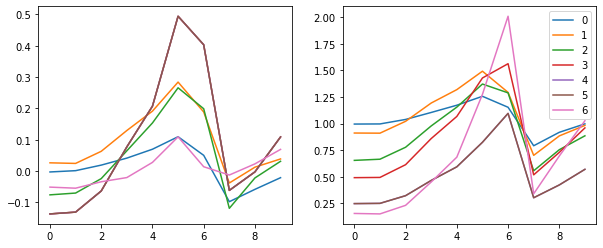

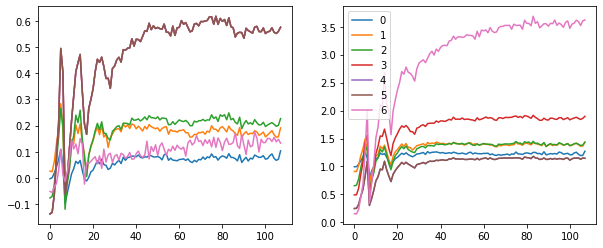

In [149]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10, 4))
for h in hooks:
    ms, ss, _ = h.stats
    ax0.plot(ms[:10])
    ax1.plot(ss[:10])
    h.remove()
plt.legend(range(len(hooks)))

fig, (ax0, ax1) = plt.subplots(1, 2, figsize = (10, 4))
for h in hooks:
    ms, ss, _ = h.stats
    ax0.plot(ms)
    ax1.plot(ss)
    h.remove()
plt.legend(range(len(hooks)))

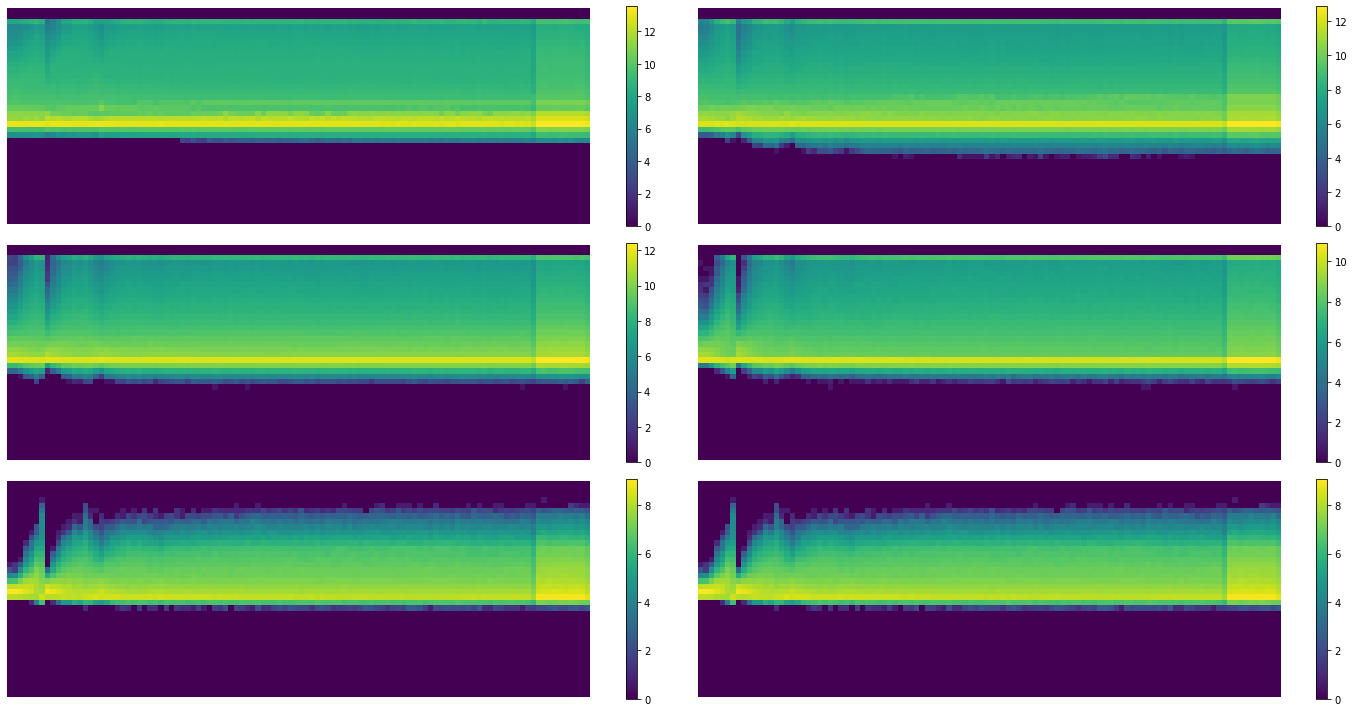

In [155]:
fig, axes = plt.subplots(3, 2, figsize=(20,10))
# axes.shape, axes.flatten().shape
for ax, h in zip(axes.flatten(), hooks[:6]):
    img = ax.imshow(get_hist(h), origin='lower')
    hi = get_hist(h)
    # bar = plt.colorbar(ax)
    ax.axis('off')
    plt.colorbar(img, ax = ax)
plt.tight_layout()

hi.t().max(-1).values, hi.t().min3(-1).values

In [167]:
hi.t().max(-1).values, hi.t().min3(-1).values

(tensor([9.0743, 9.0599, 8.9061, 8.6332, 8.4029, 7.9882, 8.4016, 8.8650, 8.7881,
         8.5497, 8.3306, 8.2155, 8.2139, 8.1854, 8.3057, 8.3754, 8.5531, 8.3934,
         8.4517, 8.4418, 8.4403, 8.3559, 8.3362, 8.3214, 8.3354, 8.3591, 8.4290,
         8.3502, 8.4442, 8.3347, 8.3445, 8.3175, 8.3178, 8.3270, 8.3000, 8.3013,
         8.3055, 8.2883, 8.2290, 8.2993, 8.2351, 8.2517, 8.2759, 8.1956, 8.2066,
         8.2139, 8.1887, 8.2314, 8.2003, 8.2123, 8.2000, 8.1964, 8.2420, 8.1421,
         8.2217, 8.1817, 8.2388, 8.1371, 8.2292, 8.1781, 8.1978, 8.1336, 8.1719,
         8.1691, 8.1942, 8.2174, 8.2066, 8.1654, 8.1770, 8.1951, 8.1559, 8.1803,
         8.1571, 8.1513, 8.1098, 8.1215, 8.1688, 8.1250, 8.1556, 8.1453, 8.1724,
         8.1318, 8.1724, 8.1447, 8.1992, 8.1984, 8.2377, 8.1710, 8.2571, 8.2044,
         8.2164, 8.1915, 8.1978, 8.2003, 8.2451, 8.2030, 8.2052, 7.7706, 8.9189,
         8.8945, 8.9008, 8.9164, 8.9110, 8.9111, 8.9232, 8.9018, 8.9483, 8.6293]),
 tensor([0., 0., 0., 0., 0

In [89]:
import inspect
inspect_code = lambda x: print(inspect.getsource(x))
list(map(inspect_code, [get_cnn_layers, Lambda, flatten, conv_layer]))

def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3)
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))



[None, None, None, None]

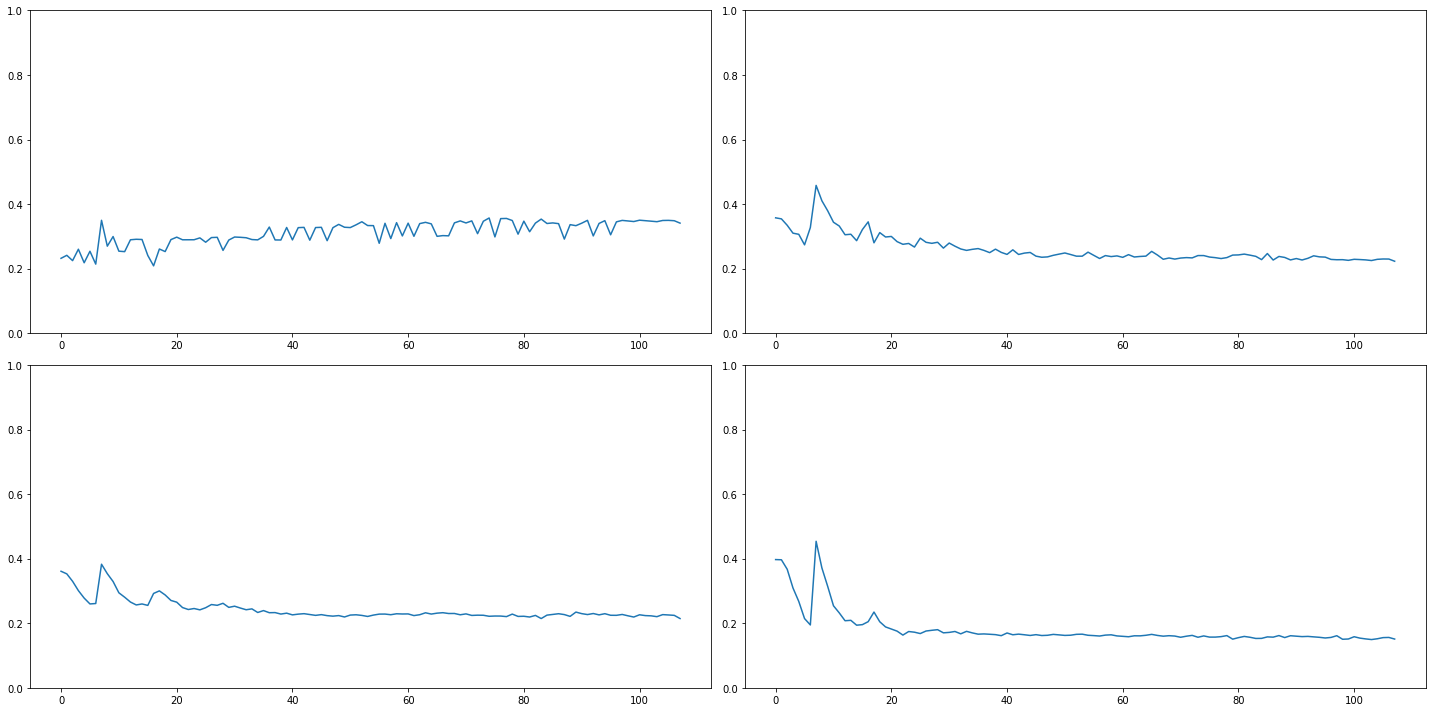

In [178]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0) / h1.sum(0)

fig, axes = plt.subplots(2, 2, figsize = (20, 10))
for ax, h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0, 1)
plt.tight_layout()

In [182]:
hi.shape, hi[19:22].shape

(torch.Size([40, 108]), torch.Size([3, 108]))

In [185]:
for idx, i in enumerate(hi):
    print(idx, i.min(), i.max())

0 tensor(0.) tensor(0.)
1 tensor(0.) tensor(0.)
2 tensor(0.) tensor(0.)
3 tensor(0.) tensor(0.)
4 tensor(0.) tensor(0.)
5 tensor(0.) tensor(0.)
6 tensor(0.) tensor(0.)
7 tensor(0.) tensor(0.)
8 tensor(0.) tensor(0.)
9 tensor(0.) tensor(0.)
10 tensor(0.) tensor(0.)
11 tensor(0.) tensor(0.)
12 tensor(0.) tensor(0.)
13 tensor(0.) tensor(0.)
14 tensor(0.) tensor(0.)
15 tensor(0.) tensor(0.)
16 tensor(0.) tensor(2.6391)
17 tensor(0.) tensor(7.3146)
18 tensor(7.7706) tensor(8.9483)
19 tensor(7.4158) tensor(9.0743)
20 tensor(7.1952) tensor(8.4063)
21 tensor(6.4394) tensor(8.0787)
22 tensor(4.3307) tensor(7.8356)
23 tensor(1.6094) tensor(7.7363)
24 tensor(0.) tensor(7.5601)
25 tensor(0.) tensor(7.3683)
26 tensor(0.) tensor(7.1724)
27 tensor(0.) tensor(7.1253)
28 tensor(0.) tensor(6.5862)
29 tensor(0.) tensor(6.1203)
30 tensor(0.) tensor(5.5947)
31 tensor(0.) tensor(4.9628)
32 tensor(0.) tensor(4.5643)
33 tensor(0.) tensor(4.3175)
34 tensor(0.) tensor(3.6636)
35 tensor(0.) tensor(2.9444)
36 ten